In [1]:
# Import libraries.
from joblib import dump, load
import pandas as pd
import numpy as np
from ModelCertifier import ModelCertifier

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from matplotlib.collections import PolyCollection
plt.rcParams["lines.linewidth"] = 1.0
plt.rcParams["font.size"] = 6.0
plt.rcParams["axes.titlesize"] = 6.0

In [2]:
# Load model.
clf = load("soh_model.joblib")
base_model = clf.best_estimator_
X = pd.read_csv("X_test.csv", index_col=0)
y = pd.read_csv("y_test.csv", index_col=0)
u_x = pd.read_csv("u_x_test.csv", index_col=0)

In [3]:
# Instantiate certifier class and perform estimation.
certifier = ModelCertifier()
X_test, predictions = certifier.estimate_uncertainty(X.values,
                                                     y.values.ravel(),
                                                     base_model,
                                                     u_x,
                                                     X_test=X.values)

# Save data.
pd.DataFrame(predictions).to_csv("MC_simulations.csv")

In [4]:
# Load data.
predictions = pd.read_csv("MC_simulations.csv")

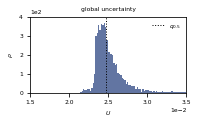

In [138]:
q_50 = np.quantile(2 * np.std(predictions, axis=1), q=0.5)
fig, axes = plt.subplots(1, 1, figsize=(2.8, 0.5*2.8), sharex=True, sharey=True, facecolor="white")
axes.set_title(r"global uncertainty")
axes.hist(2 * np.std(predictions, axis=1), bins=np.linspace(2e-2, 3.5e-2, 86),
          density=True, 
          color=plt.cm.viridis(0.25),
          alpha=0.8)
plt.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
axes.plot([q_50, q_50], [0, 400], ":", color="k", label=r"$q_{0.5}$")
axes.set_xlabel(r"$U$")
axes.set_ylabel(r"$\rho$")
axes.set_xlim(1.5e-2, 3.5e-2)
axes.set_ylim(0, 4e2)
axes.legend(frameon=False)
plt.savefig("./figures/soh/uncertainty.png", dpi=1200, orientation='landscape', bbox_inches='tight')
plt.show()

In [15]:
# Quantiles of uncertainty distribution.
q = [0.05, 0.25, 0.5, 0.75, 0.95]  # quantiles
pd.DataFrame(np.quantile(2 * np.std(predictions, axis=1), q=q), index=q, columns=["SOH"])

,SOH
0.05,0.023344
0.25,0.023988
0.50,0.024691
0.75,0.025850
0.95,0.029013


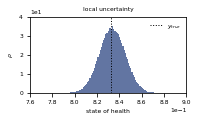

In [123]:
index = 200
fig, axes = plt.subplots(1, 1, figsize=(2.8, 0.5*2.8), sharex=True, sharey=True, facecolor="white")
axes.set_title(r"local uncertainty")
axes.hist(predictions[index, :], bins=101,
          density=True, 
          color=plt.cm.viridis(0.25),
          alpha=0.8)
axes.plot([y.SOH[index], y.SOH[index]], [0, 40], ":", color="k", label=r"$y_{true}$")
plt.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
axes.set_xlabel(r"state of health")
axes.set_ylabel(r"$\rho$")
axes.set_xlim(7.6e-1, 9e-1)
axes.set_ylim(0, 40)
axes.legend(frameon=False)
plt.savefig("./figures/soh/uncertainty_single.png", dpi=1200, orientation='landscape', bbox_inches='tight')
plt.show()

In [132]:
B = 20
M = 10000
model_averages = np.zeros((predictions.shape[0], B))
for b in range(B):
    model_averages[:, b] = np.mean(predictions[:, b * M : (b + 1) * M], axis=1)
print("The model uncertainty is", np.median(np.std(model_averages, axis=1)), ".")

The model uncertainty is 0.0013385957847425157 .


In [171]:
# Uncertainty Budget
u_m = np.median(np.std(model_averages, axis=1))
u_y = np.quantile(np.std(predictions, axis=1), q=0.5)
sigma_y = 8.2e-3
u_x = np.sqrt(u_y ** 2 - u_m ** 2 - sigma_y ** 2)
print("The input uncertainty is", u_x, ".")

The input uncertainty is 0.009131044501397212 .


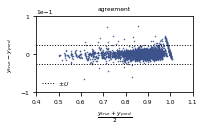

In [122]:
U = 2 * np.median(np.std(predictions, axis=1))
y_pred = np.mean(predictions, axis=1)
x1, x2 = (y.values.ravel() + y_pred) / 2, y.values.ravel() - y_pred

fig, axes = plt.subplots(1, 1, figsize=(2.8, 0.5*2.8), sharex=True, sharey=True, facecolor="white")
axes.set_title("agreement")
axes.plot(x1, x2, ".", ms=1, color=plt.cm.viridis(0.25))
axes.plot([0.4, 1.1], [U, U], ":", color="k", alpha=1.0, label=r"$\pm U$")
axes.plot([0.4, 1.1], [-U, -U], ":", color="k", alpha=1.0)
axes.set_xlabel(r"$\dfrac{y_{true}+y_{pred}}{2}$")
axes.set_ylabel(r"$y_{true}-y_{pred}$")
axes.set_xlim(0.4, 1.1)
axes.set_ylim(-0.1, 0.1)
axes.set_yticks(np.linspace(-0.1, 0.1, 3))
axes.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
axes.legend(frameon=False, loc=3)
plt.savefig("./figures/soh/Bland_Altmann.png", dpi=1200, orientation='landscape', bbox_inches='tight')
plt.show()

In [172]:
print("The percentage of points outside of the confidence is", np.round((np.sum(((x2 > U) | (x2 < -U))) / np.count_nonzero(x2)) * 100, 1), "%.")

The percentage of points outside of the confidence is 1.9 %.
